In [42]:
### Basic Setup

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from joblib import Memory
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import StandardScaler
    import xgboost as xgb

%matplotlib inline

pd.options.display.max_columns = None
sns.set(style="darkgrid")

memory = Memory(location='cache', verbose=0)

In [43]:
def null_cnt(col):
    return col.isnull().sum()

def null_pct(col):
    return null_cnt(col) / len(col)

def cache_plot(path, clear_cache=False):
    def cache_plot_decorator(func):
        import os.path
        from IPython.display import Image
        import matplotlib.pyplot as plt
        def function_wrapper(*args, **kwargs):
            if clear_cache:
                try:
                    os.remove(path)
                except:
                    pass
            if not os.path.isfile(path):
                func(*args, **kwargs)
                plt.savefig(path, bbox_inches="tight")
                plt.close()
            return Image(filename=path)
        return function_wrapper
    return cache_plot_decorator

In [44]:
train = pd.read_csv('cleaned_data/train.csv', na_filter = False)
train.set_index('Id', inplace=True)
test = pd.read_csv('cleaned_data/test.csv', na_filter = False)
test.set_index('Id', inplace=True)

In [45]:
num_cols = list(train.select_dtypes(include=np.number).columns)
corrs = train[num_cols].corr()['SalePrice']
corrs.sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
GarageYrBlt      0.261366
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
LotFrontage      0.209624
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

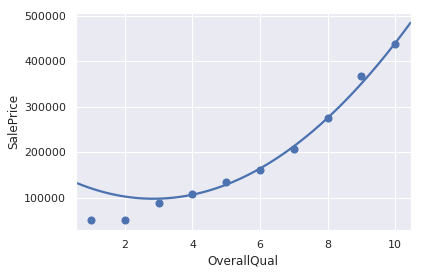

In [46]:
sns.regplot(x='OverallQual', y='SalePrice', x_estimator=np.mean, order=2, ci=None, data=train)

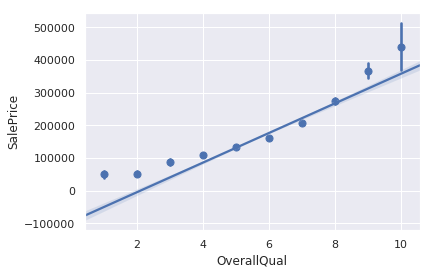

In [47]:
sns.regplot(x='OverallQual', y='SalePrice', x_estimator=np.mean, data=train)

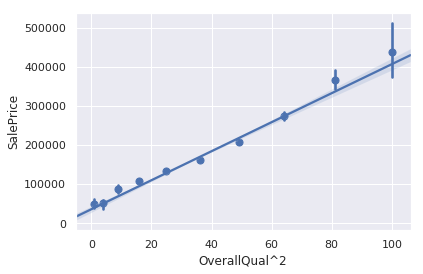

In [48]:
train['OverallQual^2'] = train['OverallQual']**2
sns.regplot(x='OverallQual^2', y='SalePrice', x_estimator=np.mean, data=train)

In [49]:
test['OverallQual^2'] = test['OverallQual']**2

In [50]:
live_area_cols = ['GrLivArea', 'TotRmsAbvGrd', 'FullBath', 'HalfBath', 'SalePrice']
train[live_area_cols].corr()

,GrLivArea,TotRmsAbvGrd,FullBath,HalfBath,SalePrice
GrLivArea,1.000000,0.825489,0.630012,0.415772,0.708624
TotRmsAbvGrd,0.825489,1.000000,0.554784,0.343415,0.533723
FullBath,0.630012,0.554784,1.000000,0.136381,0.560664
HalfBath,0.415772,0.343415,0.136381,1.000000,0.284108
SalePrice,0.708624,0.533723,0.560664,0.284108,1.000000


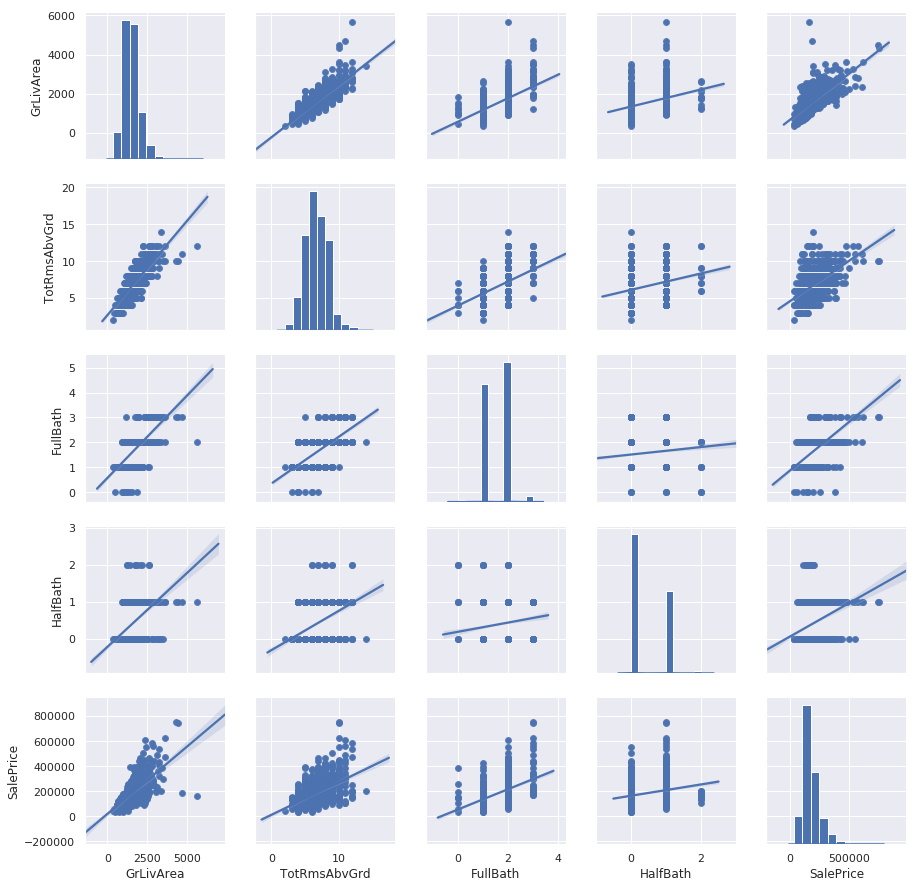

In [51]:
@cache_plot('cache/live_area_cols_graph.png')
def pairplot(train, live_area_cols):
    g = sns.pairplot(train[live_area_cols])
    g.map_diag(sns.kdeplot)
    g.map_offdiag(sns.regplot)

pairplot(train, live_area_cols)

0.7086244776126511

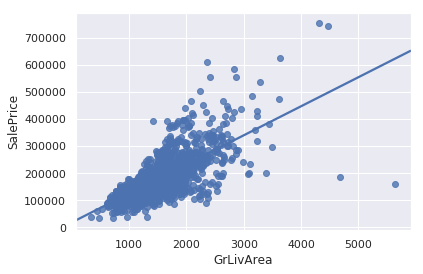

In [52]:
sns.regplot(x='GrLivArea', y='SalePrice', ci=None, data=train)
corrs['GrLivArea']

0.7349681645359343

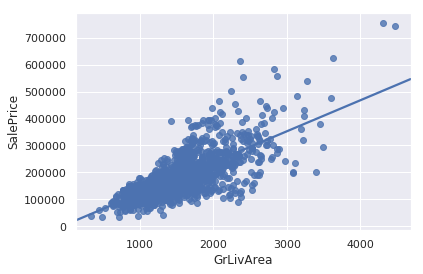

In [53]:
gla_no_outliers = train[(train['GrLivArea'] < 4000) | (train['SalePrice'] > 200000)]
sns.regplot(x='GrLivArea', y='SalePrice', ci=None, data=gla_no_outliers)
gla_no_outliers.corr().loc['SalePrice', 'GrLivArea']

In [54]:
train = gla_no_outliers.copy()

0.5377688162416036

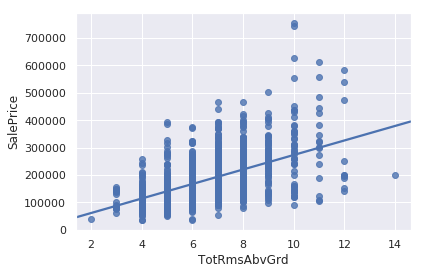

In [55]:
sns.regplot(x='TotRmsAbvGrd', y='SalePrice', ci=None, data=train)
train.corr().loc['SalePrice', 'TotRmsAbvGrd']

0.5374617670292905

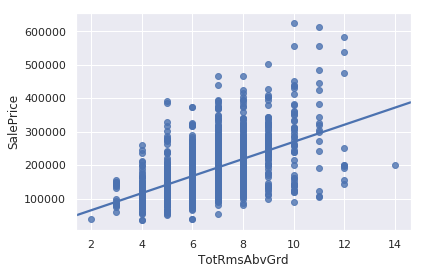

In [56]:
trag_no_outliers = train[train['SalePrice'] < 700000]
sns.regplot(x='TotRmsAbvGrd', y='SalePrice', ci=None, data=trag_no_outliers)
trag_no_outliers.corr().loc['SalePrice', 'TotRmsAbvGrd']

In [57]:
train = trag_no_outliers.copy()

In [58]:
quality_cols_mapping = {
    'NA' : 0,
    'Po': 1,
    'Fa': 2, 
    'TA': 3,
    'Gd': 4,
    'Ex': 5
}

qual_cols = [
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond',
 'PoolQC'
]

In [59]:
train[qual_cols] = train[qual_cols].apply(lambda col: col.map(quality_cols_mapping))
test[qual_cols] = test[qual_cols].apply(lambda col: col.map(quality_cols_mapping))
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SalePrice,OverallQual^2
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,5,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,4,8,Typ,0,0,Attchd,2003.0,RFn,2.0,548.0,3,3,Y,0,61,0,0,0,0,0,NA,NA,0,2,2008,208500,49
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,5,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,Typ,1,3,Attchd,1976.0,RFn,2.0,460.0,3,3,Y,298,0,0,0,0,0,0,NA,NA,0,5,2007,181500,36
3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,5,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,4,6,Typ,1,3,Attchd,2001.0,RFn,2.0,608.0,3,3,Y,0,42,0,0,0,0,0,NA,NA,0,9,2008,223500,49
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,4,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,4,7,Typ,1,4,Detchd,1998.0,Unf,3.0,642.0,3,3,Y,0,35,272,0,0,0,0,NA,NA,0,2,2006,140000,49
5,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,5,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,4,9,Typ,1,3,Attchd,2000.0,RFn,3.0,836.0,3,3,Y,192,84,0,0,0,0,0,NA,NA,0,12,2008,250000,64


In [60]:
corrs = train[qual_cols + ['SalePrice']].corr()['SalePrice'].sort_values(ascending=False)
corrs

SalePrice      1.000000
ExterQual      0.694628
KitchenQual    0.666217
BsmtQual       0.592073
FireplaceQu    0.528841
HeatingQC      0.435081
GarageQual     0.281419
GarageCond     0.270343
BsmtCond       0.219340
PoolQC         0.032199
ExterCond      0.021999
Name: SalePrice, dtype: float64

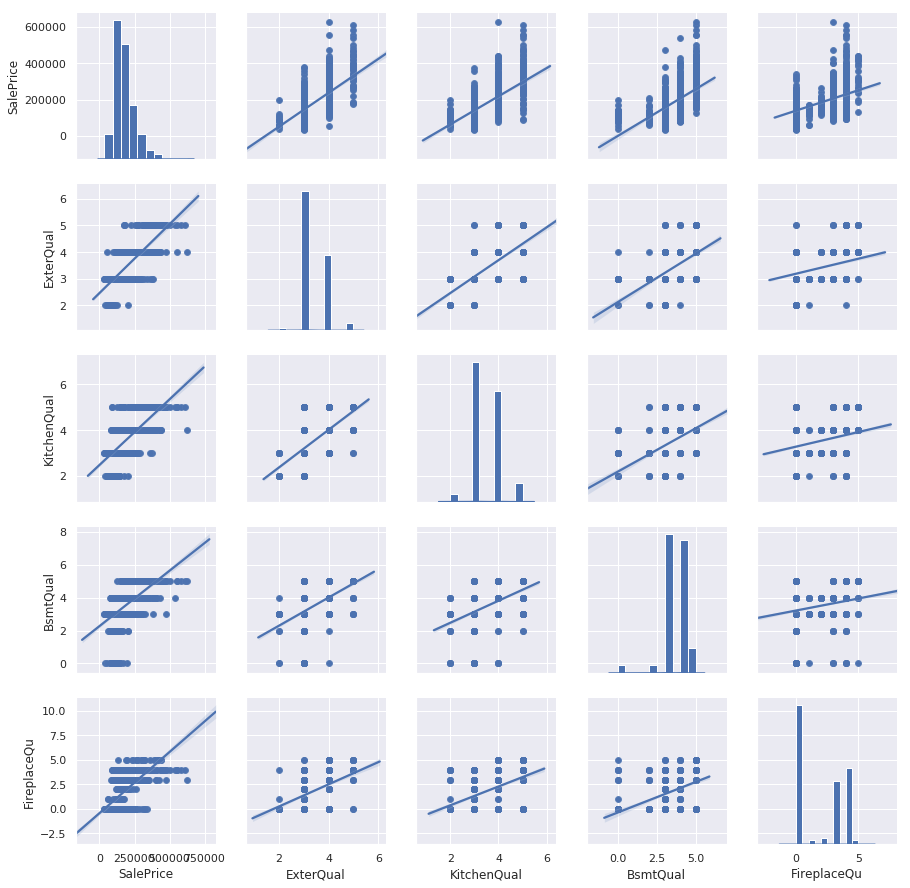

In [61]:
strong_corrs = corrs.loc[:'FireplaceQu'].index

@cache_plot('cache/qual_cols_corr_plot.png')
def qual_cols_corr_plot(train, qual_cols):
    g = sns.pairplot(train[qual_cols])
    g.map_diag(sns.kdeplot)
    g.map_offdiag(sns.regplot)

qual_cols_corr_plot(train, strong_corrs)

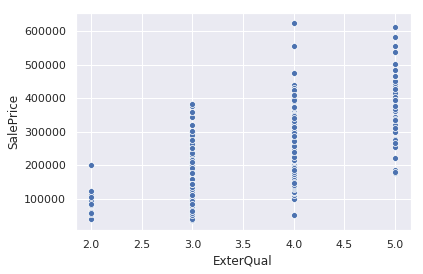

In [62]:
sns.scatterplot(x='ExterQual', y='SalePrice', data=train)

0.7033018010026311

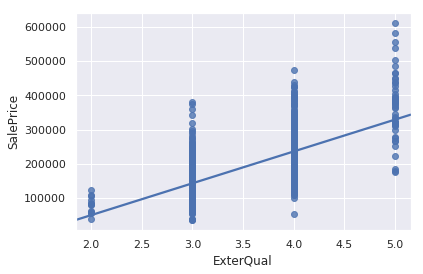

In [63]:
eq_no_outliers = train[~(
    ((train['ExterQual'] == 2) & (train['SalePrice'] > 180_000)) |
    ((train['ExterQual'] == 4) & (train['SalePrice'] > 500_000))
)]
sns.regplot(x='ExterQual', y='SalePrice', ci=None, data=eq_no_outliers)
eq_no_outliers.corr().loc['SalePrice', 'ExterQual']

In [64]:
train = eq_no_outliers.copy()

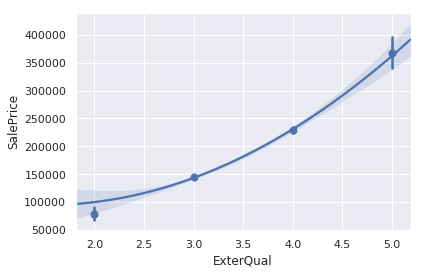

In [65]:
sns.regplot(x='ExterQual', y='SalePrice', order=2, x_estimator=np.mean, data=train)

0.7103723726940655

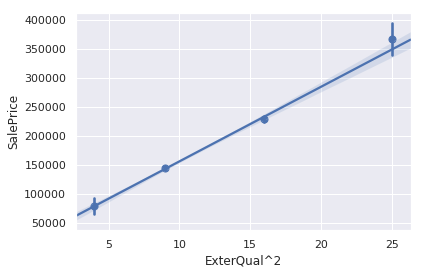

In [66]:
train['ExterQual^2'] = train['ExterQual']**2
test['ExterQual^2'] = test['ExterQual']**2
sns.regplot(x='ExterQual^2', y='SalePrice', x_estimator=np.mean, data=train)
train.corr().loc['SalePrice', 'ExterQual^2']

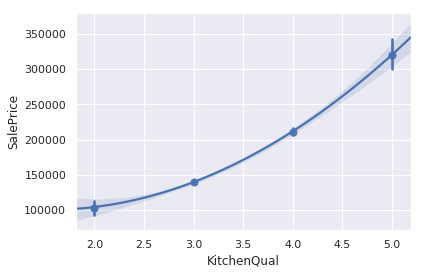

In [67]:
sns.regplot(x='KitchenQual', y='SalePrice', order=2, x_estimator=np.mean, data=train)

0.6827931857106704

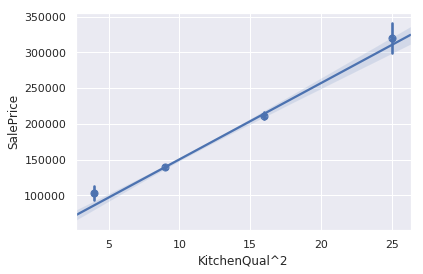

In [68]:
train['KitchenQual^2'] = train['KitchenQual']**2
test['KitchenQual^2'] = test['KitchenQual']**2
sns.regplot(x='KitchenQual^2', y='SalePrice', x_estimator=np.mean, data=train)
train.corr().loc['SalePrice', 'KitchenQual^2']

In [69]:
X = train.select_dtypes(include=np.number)
X.pop('SalePrice')
y = train['SalePrice']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_test = test.select_dtypes(include=np.number)
X_test_scaled = scaler.transform(X_test)

X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,OverallQual^2,ExterQual^2,KitchenQual^2
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,4,3,4,3,706.0,0.0,150.0,856.0,5,856,854,0,1710,1.0,0.0,2,1,3,1,4,8,0,0,2003.0,2.0,548.0,3,3,0,61,0,0,0,0,0,0,2,2008,49,16,16
2,20,80.0,9600,6,8,1976,1976,0.0,3,3,4,3,978.0,0.0,284.0,1262.0,5,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,1,3,1976.0,2.0,460.0,3,3,298,0,0,0,0,0,0,0,5,2007,36,9,9
3,60,68.0,11250,7,5,2001,2002,162.0,4,3,4,3,486.0,0.0,434.0,920.0,5,920,866,0,1786,1.0,0.0,2,1,3,1,4,6,1,3,2001.0,2.0,608.0,3,3,0,42,0,0,0,0,0,0,9,2008,49,16,16
4,70,60.0,9550,7,5,1915,1970,0.0,3,3,3,4,216.0,0.0,540.0,756.0,4,961,756,0,1717,1.0,0.0,1,0,3,1,4,7,1,4,1998.0,3.0,642.0,3,3,0,35,272,0,0,0,0,0,2,2006,49,9,16
5,60,84.0,14260,8,5,2000,2000,350.0,4,3,4,3,655.0,0.0,490.0,1145.0,5,1145,1053,0,2198,1.0,0.0,2,1,4,1,4,9,1,3,2000.0,3.0,836.0,3,3,192,84,0,0,0,0,0,0,12,2008,64,16,16


In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

@memory.cache
def score_linear_regression(X, y):
    lr = LinearRegression()
    scores = cross_val_score(lr, X, y, cv=10, scoring='neg_mean_squared_error')
    rmses = (-scores)**.5
    return (lr, np.mean(rmses), np.std(rmses))

lr, rmse, std = score_linear_regression(X, y)
(rmse, std)

(24482.530406163503, 2188.3726710225187)

In [71]:
# search = GridSearchCV(
#     estimator=RandomForestRegressor(random_state=42),
#     param_grid={ 
#         'n_estimators': [200, 500],
#         'max_features': ['auto', 'sqrt', 'log2'],
#         'max_depth': [2, 20, 100],
#         'min_samples_split': [2, 10],
#         'min_samples_leaf': [1, 10]
#     },
#     cv=10,
#     scoring='neg_mean_squared_error',
#     verbose=2
# )
# search.fit(X, y)
# (search.best_params_, (-search.best_score_)**.5)

# ({'max_depth': 100,
#   'max_features': 'sqrt',
#   'min_samples_leaf': 1,
#   'min_samples_split': 2,
#   'n_estimators': 500},
#  25511.79300078423)

In [72]:
from sklearn.ensemble import RandomForestRegressor

@memory.cache
def score_random_forest(X, y):
    rfr = RandomForestRegressor(
        max_depth=100,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=500,
        random_state=42
    )
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_squared_error')
    rmses = (-scores)**.5
    return (rfr, np.mean(rmses), np.std(rmses))

rfr, rmse, std = score_random_forest(X, y)
(rmse, std)

(24908.930887471804, 3001.247672448532)

In [73]:
@memory.cache
def score_xgb(X, y):
    search = GridSearchCV(
        estimator=xgb.XGBRegressor(random_state=42, n_jobs=-1),
        param_grid={ 
            'n_estimators': [500, 1000, 1500],
            'learning_rate': [.5, .1, .3],
            'max_depth': [2, 5, 10]
        },
        cv=10,
        scoring='neg_mean_squared_error',
        verbose=2
    )
    search.fit(X, y)
    return (search.best_estimator_, search.best_params_, (-search.best_score_)**.5)

xgbr, params, rmse = score_xgb(X, y)
(params, rmse)

({'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000},
 22619.754477201073)

In [79]:
def fit_predict(est, X, y):
    return est.fit(X, y).predict(X)

In [80]:
from sklearn.metrics import mean_squared_error

lr_preds = fit_predict(lr, X, y)
rfr_preds = fit_predict(rfr, X, y)
xgbr_preds = fit_predict(xgbr, X, y)

lr_rmse = mean_squared_error(y, lr_preds)**.5
rfr_rmse = mean_squared_error(y, rfr_preds)**.5
xgbr_rmse = mean_squared_error(y, xgbr_preds)**.5

(lr_rmse, rfr_rmse, xgbr_rmse)

(23129.329564075764, 9150.087446672127, 10322.938315773803)

In [81]:
X_test = test.select_dtypes(include=np.number)

lr_preds = lr.predict(X_test)
rfr_preds = rfr.predict(X_test)
xgbr_preds = xgbr.predict(X_test)

preds = (lr_preds + rfr_preds + xgbr_preds) / 3

In [82]:
submissions = pd.DataFrame({
    "Id": X_test.index,
    "SalePrice": preds
})
submissions.to_csv('submission.csv', index=False)